# Problem Set - Week 5
## Guillermo Trefogli

In [1]:
! pip install sktime
! pip install pmdarima

You should consider upgrading via the 'C:\Users\guill\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\guill\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.all import ForecastingHorizon
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\guill\anaconda3\lib\site-packages\sktime\utils\validation\_dependencies.py:64: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


## 1. EDA

### 1.A 

In [3]:
df_co2 = pd.read_csv('hw5_data_co2.csv', parse_dates = ['ds'])
df_temp = pd.read_csv('hw5_data_temp.csv', parse_dates = ['ds'])

In [4]:
print(df_co2.isnull().sum())
print(df_temp.isnull().sum())

print(df_co2.shape)
print(df_temp.shape)

ds     0
co2    0
dtype: int64
ds      0
temp    0
dtype: int64
(735, 2)
(1674, 2)


In [5]:
from datetime import datetime, timedelta
df_co2['ds'] = df_co2['ds'] - timedelta(days=14)
df = pd.merge(df_co2, df_temp, how = "inner", on = "ds")
df

,ds,co2,temp
0,1958-03-01,315.700,57.38
1,1958-04-01,317.450,57.29
2,1958-05-01,317.510,57.32
3,1958-06-01,316.685,57.02
4,1958-07-01,315.860,57.27
...,...,...,...
730,2019-01-01,410.920,58.29
731,2019-02-01,411.660,58.37
732,2019-03-01,412.000,58.59
733,2019-04-01,413.510,58.50


### 1.B. 
- One dataset provides information for temperature, the other for CO2.
- There are no missing values in the dataset.
- Both variables are similar in terms of time series pattern: increasing trend over time.
- ACF plot shows autocorrelation in time for temperature

In [6]:
df.set_index('ds', inplace = True)
df

,co2,temp
ds,,
1958-03-01,315.700,57.38
1958-04-01,317.450,57.29
1958-05-01,317.510,57.32
1958-06-01,316.685,57.02
1958-07-01,315.860,57.27
...,...,...
2019-01-01,410.920,58.29
2019-02-01,411.660,58.37
2019-03-01,412.000,58.59


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,735.0,354.210673,27.922811,313.20,328.785,351.34,376.515,414.83
temp,735.0,57.603293,0.397159,56.73,57.280,57.59,57.915,58.84


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


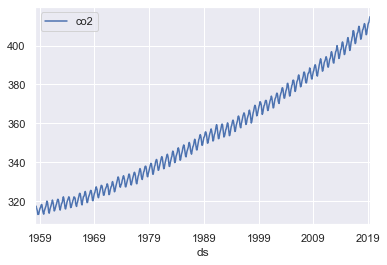

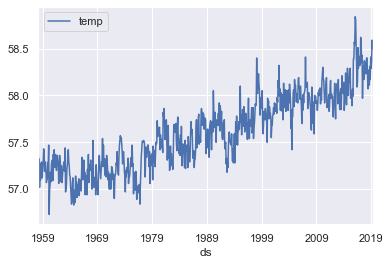

In [8]:
print(df[['co2']].plot())
print(df[['temp']].plot())

In [9]:
df.corr()

,co2,temp
co2,1.000000,0.898635
temp,0.898635,1.000000


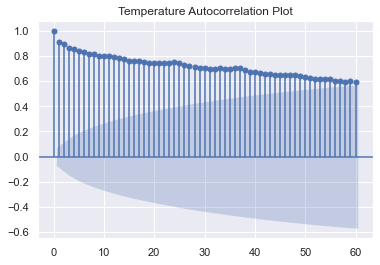

In [10]:
p = plot_acf(df['temp'], lags=60, title='Temperature Autocorrelation Plot')

## Part 2. ARIMA with external regressors

### 2.A. 
- Our variable of interest CO2 initially shows no stationarity:

    - **ADF test** is showing that **non-stationarity can be rejected**. The p-value in the test is lower than 0.05, which means that the null hypothesis of non-stationarity can be rejected.
    - **KPSS test** is showing that **stationarity in the time series can be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series can be rejected.

- Based on ACF and PACF, we can differentiate it to make the time series stational:

    - **ADF test** is showing that **non-stationarity can be rejected**. The p-value in the test is lower than 0.05, which means that the null hypothesis of non-stationarity can be rejected.
    - **KPSS test** is showing that **stationarity in the time series cannot be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series cannot be rejected.

- See below plots and tests outputs.

In [11]:
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

<AxesSubplot:xlabel='ds'>

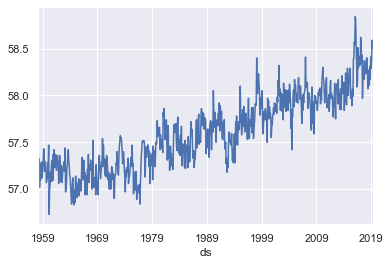

In [12]:
ts_temp = df.groupby(pd.PeriodIndex(df.index, freq="M"))['temp'].mean()
ts_temp.plot()

In [13]:
bctransformer = boxcox.BoxCoxTransformer()
ts_transf = bctransformer.fit_transform(ts_temp)

In [14]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(ts_temp)

In [15]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

def adf_test(timeseries):
    print ('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [16]:
adf_test(y_train)

Dickey-Fuller Test Result:
Test Statistic                  -2.481183
p-value                          0.120120
#Lags Used                       4.000000
Number of Observations Used    546.000000
Critical Value (1%)             -3.442384
Critical Value (5%)             -2.866848
Critical Value (10%)            -2.569597
dtype: float64


In [17]:
kpss_test(y_train)

KPSS Test Result:
Test Statistic            2.443554
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### Differenting

In [18]:
y_train_seasdiff = y_train.diff(12).dropna()

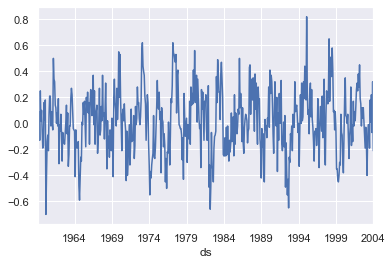

In [19]:
y_train_seasdiff.plot()
plt.show()

In [20]:
adf_test(y_train_seasdiff)

Dickey-Fuller Test Result:
Test Statistic                -7.250434e+00
p-value                        1.785978e-10
#Lags Used                     1.300000e+01
Number of Observations Used    5.250000e+02
Critical Value (1%)           -3.442867e+00
Critical Value (5%)           -2.867061e+00
Critical Value (10%)          -2.569710e+00
dtype: float64


In [21]:
kpss_test(y_train_seasdiff)

KPSS Test Result:
Test Statistic            0.055558
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


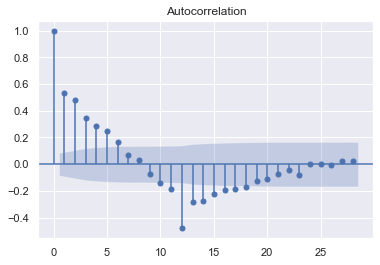

In [22]:
plot_acf(y_train_seasdiff)
plt.show()

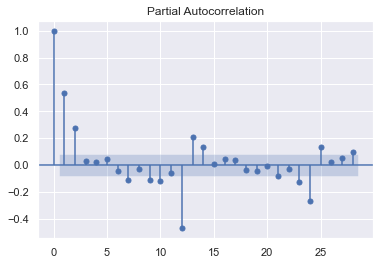

In [23]:
plot_pacf(y_train_seasdiff)
plt.show()

In [24]:
#y_train_nonseasdiff = np.diff(y_train_seasdiff)
y_train_nonseasdiff = y_train_seasdiff.diff(12).dropna()

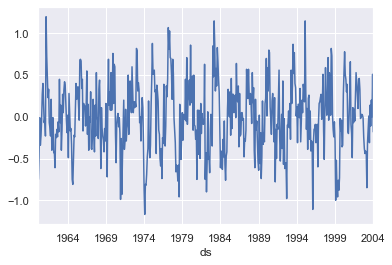

In [25]:
y_train_nonseasdiff.plot()
plt.show()

In [26]:
adf_test(y_train_nonseasdiff)

Dickey-Fuller Test Result:
Test Statistic                -7.555800e+00
p-value                        3.102015e-11
#Lags Used                     1.300000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64


In [27]:
kpss_test(y_train_nonseasdiff)

KPSS Test Result:
Test Statistic            0.014908
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


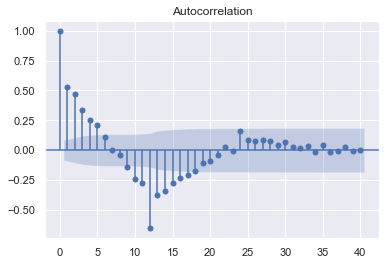

In [28]:
plot_acf(y_train_nonseasdiff, lags = 40)
plt.show()

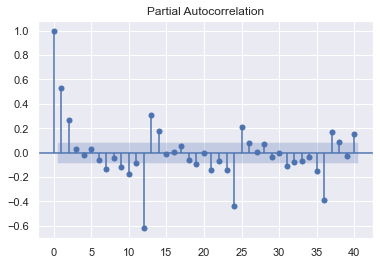

In [29]:
plot_pacf(y_train_nonseasdiff, lags = 40)
plt.show()

### 2.B. 

### ARIMA model:

In [30]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(3,1,1), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                 117.306
Date:                             Fri, 13 May 2022   AIC                           -224.612
Time:                                     19:02:29   BIC                           -203.173
Sample:                                 03-31-1958   HQIC                          -216.226
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3834      0.045      8.582      0.000       0.296       0.471
ar.L2          0.2618      

In [31]:
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))

AICc for order (3, 1, 1)(0, 1, 0, 12): -224.49933593395673


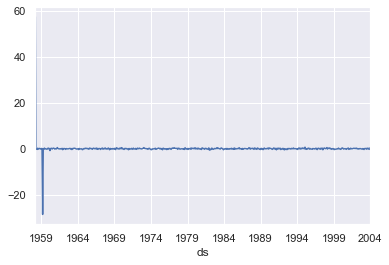

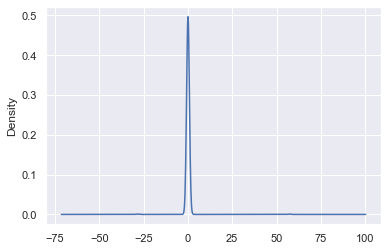

count    551.000000
mean       0.055179
std        2.739115
min      -28.550001
25%       -0.120319
50%        0.000031
75%        0.125901
max       57.380000
dtype: float64


In [32]:
residuals = sarima_fit.resid
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [33]:
residuals

ds
1958-03    57.380000
1958-04    -0.089999
1958-05     0.030000
1958-06    -0.300000
1958-07     0.250000
             ...    
2003-09    -0.014316
2003-10     0.169001
2003-11    -0.167531
2003-12     0.283682
2004-01    -0.326246
Freq: M, Length: 551, dtype: float64

In [34]:
resid = residuals[24:]
resid

ds
1960-03   -0.797803
1960-04   -0.144213
1960-05    0.220340
1960-06    0.107152
1960-07   -0.110869
             ...   
2003-09   -0.014316
2003-10    0.169001
2003-11   -0.167531
2003-12    0.283682
2004-01   -0.326246
Freq: M, Length: 527, dtype: float64

<AxesSubplot:xlabel='ds'>

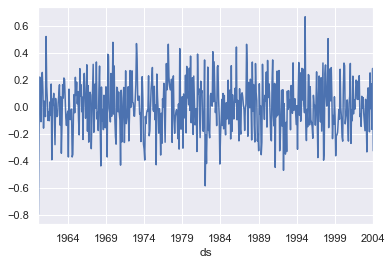

In [35]:
resid.plot()

<AxesSubplot:>

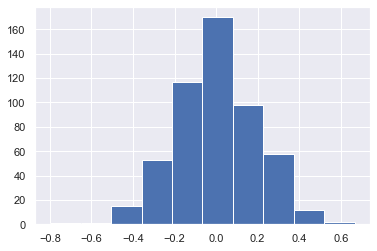

In [36]:
resid.hist()

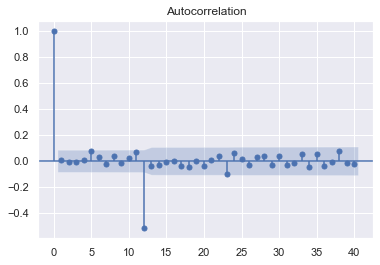

In [37]:
plot_acf(resid, lags = 40)
plt.show()

In [38]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,5.370023,0.86513,5.28887,0.871065


### AUTOarima model:

In [39]:
from sktime.forecasting.arima import AutoARIMA
from pmdarima.arima import auto_arima

In [40]:
y_train, y_test = temporal_train_test_split(ts_temp)

In [41]:
y_train.index.min(), y_train.index.max()

(Period('1958-03', 'M'), Period('2004-01', 'M'))

In [42]:
y_test.index.min(), y_test.index.max()

(Period('2004-02', 'M'), Period('2019-05', 'M'))

In [43]:
auto_arima = auto_arima(y_train, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(auto_arima.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-53.968, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-345.175, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-167.230, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-395.722, Time=0.40 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-284.630, Time=0.22 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-405.606, Time=0.52 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-353.561, Time=0.27 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.32 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-424.092, Time=0.77 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-367.33

In [44]:
print(auto_arima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 223.904
Date:                             Fri, 13 May 2022   AIC                           -433.808
Time:                                     19:03:24   BIC                           -403.793
Sample:                                          0   HQIC                          -422.067
                                             - 551                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0340      0.134      0.255      0.799      -0.228       0.296
ar.L2          0.0367      

Figure(864x576)


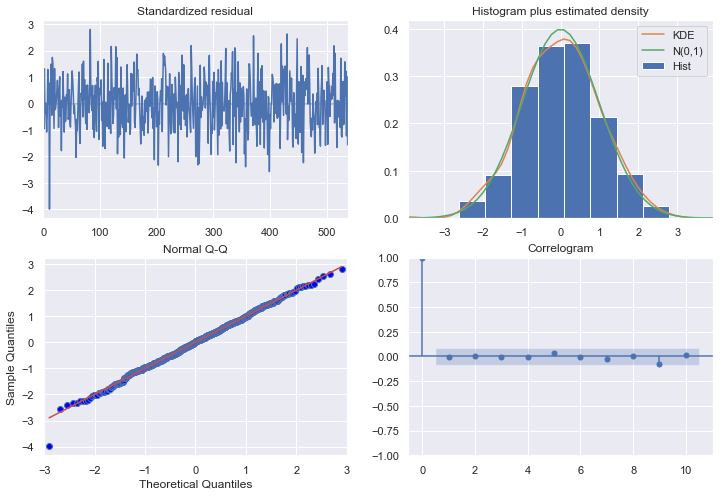

In [45]:
print(auto_arima.plot_diagnostics(figsize=(12,8)))

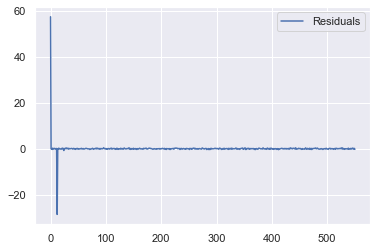

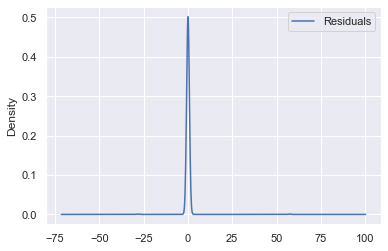

        Residuals
count  551.000000
mean     0.052828
std      2.736996
min    -28.550000
25%     -0.108645
50%      0.006010
75%      0.110697
max     57.380000


In [46]:
res = auto_arima.resid()
residuals = pd.DataFrame(res,columns=["Residuals"])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [47]:
resid = residuals[24:]
resid

,Residuals
24,-0.763387
25,-0.015781
26,0.144977
27,0.252901
28,-0.074602
...,...
546,0.046741
547,0.194461
548,-0.193676
549,0.160405


<AxesSubplot:>

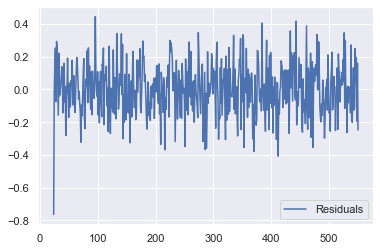

In [48]:
resid.plot()

array([[<AxesSubplot:title={'center':'Residuals'}>]], dtype=object)

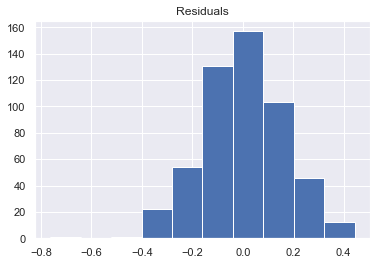

In [49]:
resid.hist()

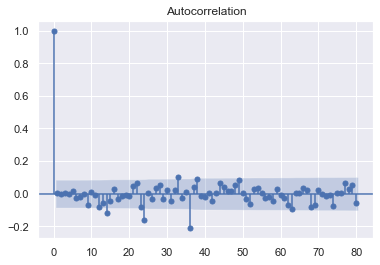

In [50]:
plot_acf(resid, lags = 80)
plt.show()

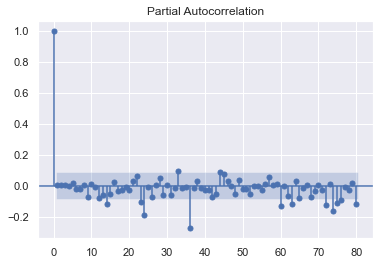

In [51]:
plot_pacf(resid, lags = 80)
plt.show()

In [52]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,3.571708,0.964607,3.501606,0.967044


### 2.C. 

In [53]:
y_pred = pd.DataFrame(auto_arima.predict(n_periods = len(y_test)), index = y_test.index)
y_pred.columns = ['pred']
y_pred

,pred
ds,
2004-02,58.028632
2004-03,58.108980
2004-04,57.984532
2004-05,58.084763
2004-06,57.916935
...,...
2019-01,58.553861
2019-02,58.521577
2019-03,58.595121


<AxesSubplot:xlabel='ds'>

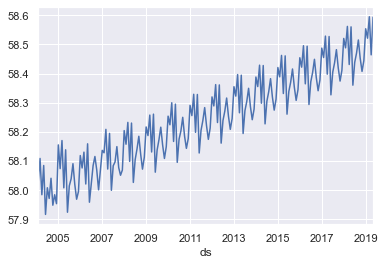

In [54]:
y_pred = y_pred.groupby(pd.PeriodIndex(y_pred.index, freq="M"))['pred'].mean()
y_pred.plot()

In [55]:
def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot()
    y_test.plot()

    y_pred.plot()

    plt.legend(['y_train','y_test','y_pred'])
    plt.show()

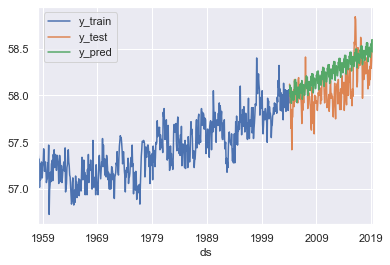

In [56]:
plot_results(y_train, y_test, y_pred)

In [57]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test, y_pred)

0.0034422509771027602

In [58]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

1.5679035270745731

In [59]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

0.20012150472842738

In [60]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

0.060428642265561126

In [61]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

0.003450304088813641

### 2.D. 

<AxesSubplot:xlabel='ds'>

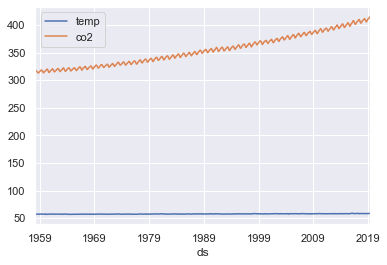

In [62]:
ts = df.groupby(pd.PeriodIndex(df.index, freq="M"))['temp', 'co2'].mean()
ts.plot()

In [63]:
y_train, y_test = temporal_train_test_split(ts)

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(endog=y_train['temp'],
                        exog = y_train['co2'],
                        order=(3,1,1),
                        trend='c',
                        seasonal_order=(2, 1, 0, 12))
sarimax_fit = sarimax_model.fit()
print(sarimax_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 224.012
Date:                             Fri, 13 May 2022   AIC                           -430.023
Time:                                     19:03:31   BIC                           -391.433
Sample:                                 03-31-1958   HQIC                          -414.928
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.151      0.880      -0.005       0.006
co2           -0.0098      

In [65]:
print("AICc for order " + str(sarimax_model.order) + str(sarimax_model.seasonal_order) +": " +str(sarimax_fit.aicc))

AICc for order (3, 1, 1)(2, 1, 0, 12): -429.68252109084307


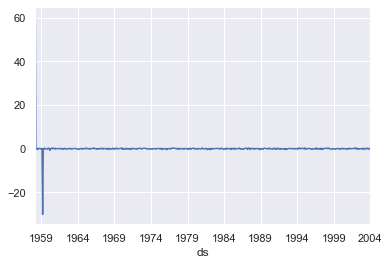

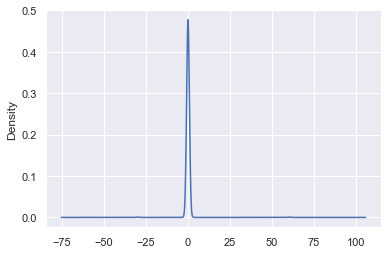

count    551.000000
mean       0.054724
std        2.884006
min      -30.093476
25%       -0.109718
50%        0.004624
75%        0.109667
max       60.469473
dtype: float64


In [66]:
# residual checks
# line plot of residuals
residuals = sarimax_fit.resid
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [67]:
residuals

ds
1958-03    60.469473
1958-04    -0.073074
1958-05     0.030386
1958-06    -0.308275
1958-07     0.241724
             ...    
2003-09     0.045375
2003-10     0.194088
2003-11    -0.197435
2003-12     0.155531
2004-01    -0.250217
Freq: M, Length: 551, dtype: float64

In [68]:
resid = residuals[24:]
resid

ds
1960-03   -0.760806
1960-04   -0.014775
1960-05    0.152667
1960-06    0.257895
1960-07   -0.072380
             ...   
2003-09    0.045375
2003-10    0.194088
2003-11   -0.197435
2003-12    0.155531
2004-01   -0.250217
Freq: M, Length: 527, dtype: float64

<AxesSubplot:xlabel='ds'>

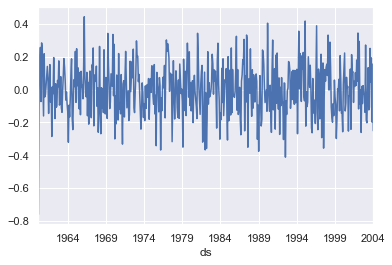

In [69]:
resid.plot()

<AxesSubplot:>

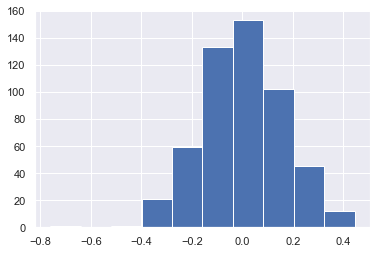

In [70]:
resid.hist()

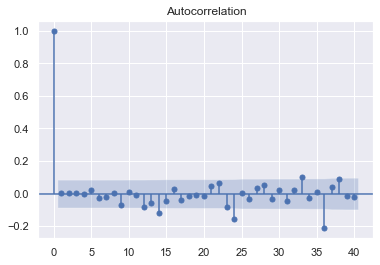

In [71]:
plot_acf(resid, lags = 40)
plt.show()

In [72]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,3.500803,0.967071,3.432384,0.969345


### 2.E. 

In [73]:
y_pred = sarimax_fit.forecast(steps = len(y_test['temp']),  exog=y_test['co2'])

In [74]:
y_train

,temp,co2
ds,,
1958-03,57.38,315.700
1958-04,57.29,317.450
1958-05,57.32,317.510
1958-06,57.02,316.685
1958-07,57.27,315.860
...,...,...
2003-09,58.02,372.980
2003-10,58.05,373.000
2003-11,57.84,374.350


In [75]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test['temp'], y_pred)

0.005250410454964572

In [76]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test['temp'], y_pred)

0.3058314847379412

In [77]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test['temp'], y_pred)

0.12794735229068624

In [78]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test['temp'], y_pred)

0.0052690523687024884

In [79]:
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 224.012
Date:                             Fri, 13 May 2022   AIC                           -430.023
Time:                                     19:03:33   BIC                           -391.433
Sample:                                 03-31-1958   HQIC                          -414.928
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.151      0.880      -0.005       0.006
co2           -0.0098      0.022     -0.450      0.653      -0.052       0.033
ar.L1          0.0164      0.146      0.112      0.910      -0.270       0.303
ar.L2          0.0278      0.089      0.314      0.754      -0.146       0.202
ar.L3         -0.1175      0.061     -1.915      0.055      -0.238       0.003
ma.L1         -0.5833      0.140     -4.153      0.000      -0.859      -0.308
ar.S.L12      -0.7435      0.041    -18.352      0.000      -0.823      -0.664
ar.S.L24      -0.3330      0.040     -8.241      0.000      -0.412      -0.254
sigma2         0.0251      0.002     16.587      0.000       0.022       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.92   Prob(JB):                         0.75
Heteroskedasticity (H):               1.13   Skew:                            -0.07
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Part 3. Prophet with additional regressors

### 3.A. 

In [80]:
! pip install pystan --user
! pip install fbprophet --user

You should consider upgrading via the 'C:\Users\guill\anaconda3\python.exe -m pip install --upgrade pip' command.


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Running setup.py clean for fbprophet
Failed to build fbprophet
    Running setup.py install for fbprophet: started
    Running setup.py install for fbprophet: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\guill\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\guill\\AppData\\Local\\Temp\\pip-install-e3l6uo9k\\fbprophet_39b38a61d4cc43f6846c6570c9f266aa\\setup.py'"'"'; __file__='"'"'C:\\Users\\guill\\AppData\\Local\\Temp\\pip-install-e3l6uo9k\\fbprophet_39b38a61d4cc43f6846c6570c9f266aa\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\guill\AppData\Local\Temp\pip-wheel-ma88shu5'
       cwd: C:\Users\guill\AppData\Local\Temp\pip-install-e3l6uo9k\fbprophet_39b38a61d4cc43f6846c6570c9f266aa\
  Complete output (10 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating bu

In [81]:
! pip install wbdata

You should consider upgrading via the 'C:\Users\guill\anaconda3\python.exe -m pip install --upgrade pip' command.


In [82]:
from util_prophet import *
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

ModuleNotFoundError: No module named 'util_prophet'

In [ ]:
y_train_prophet = y_train
y_train_prophet['ds'] = y_train_prophet.index
y_train_prophet.rename(columns={'temp':'y'}, inplace=True)

y_test_prophet = y_test
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.rename(columns={'temp':'y'}, inplace=True)

In [ ]:
y_train_prophet

In [ ]:
y_train_prophet['ds'] = y_train_prophet['ds'].dt.strftime('%Y-%m').add('-01 00:00:00.000')
print(y_train_prophet)

In [ ]:
model = Prophet()
model.fit(y_train_prophet)

In [ ]:
future_data = model.make_future_dataframe(periods=len(y_test), freq='m')

In [ ]:
forecast_data = model.predict(future_data)
forecast_data.iloc[0:3].T

In [ ]:
p = model.plot(forecast_data)

In [ ]:
forecast_data

In [ ]:
forecast_data['ds'] == y_test.index[0]

In [ ]:
ind = forecast_data[forecast_data['ds'] == y_test.index[0]].index[0]
y_pred = forecast_data[ind:]['yhat']
y_true = y_test['y']

In [ ]:
mae =  mean_absolute_error(y_pred, y_true)
mse = mean_squared_error(y_pred, y_true)
mape = mean_absolute_percentage_error(y_pred, y_true)
smape = smape(np.array(y_pred), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred, y_true, y_train=y_train['y'])

print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

### 3.B. 10 pts Adjust seasonality, changepoint priors or other methods to see if you can create a better fit model. Examine the residuals. Using the predicted values and y train, calculate the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [ ]:
model_seasonal = Prophet(seasonality_prior_scale=10, changepoint_prior_scale=5)
model_seasonal.fit(y_train_prophet)
future_data_s = model_seasonal.make_future_dataframe(periods=len(y_test), freq='m')
forecast_data_s = model_seasonal.predict(future_data_s)
forecast_data_s.iloc[0:3].T

In [ ]:
p_s = model_seasonal.plot(forecast_data_s)

In [ ]:
ind_s = forecast_data_s[forecast_data_s['ds'] == y_test.index[0]].index[0]
y_pred_s = forecast_data_s[ind:]['yhat']

In [ ]:
mae =  mean_absolute_error(y_pred_s, y_true)
mse = mean_squared_error(y_pred_s, y_true)
mape = mean_absolute_percentage_error(y_pred_s, y_true)
#smape = smape(np.array(y_pred_s), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred_s, y_true, y_train=y_train['y'])

print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
#print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

### 3.C. 10 pts Using your best prophet model, include co2 as an external regressor. Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [ ]:
y_train_prophet

In [ ]:
y_test_prophet

In [ ]:
def co2(ds):
    date = (pd.to_datetime(ds)).date()
    
    if y_train_prohet[date:].empty:
        return y_test_prohet[date:]['co2'].values[0]
    else:
        return (y_train_prophet[date:]['co2']).values[0]
    
    return 0

In [ ]:
mr = Prophet(seasonality_prior_scale=10, changepoint_prior_scale=5)
mr.add_regressor('co2')
mr.fit(y_train_prophet)
future_r = mr.make_future_dataframe(periods=len(y_test_prophet), freq='m')
future_r['co2'] = future_r['ds'].apply(co2)
forecast_r = mr.predict(future_r)

In [ ]:
forecast_r

In [ ]:
ind_r = forecast_r[forecast_r['ds'] == y_test_prophet.index[0]].index[0]
y_pred_r = forecast_r[ind:]['yhat']

mae =  mean_absolute_error(y_pred_r, y_true)
mse = mean_squared_error(y_pred_r, y_true)
mape = mean_absolute_percentage_error(y_pred_r, y_true)
#smape = smape(np.array(y_pred_s), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred_r, y_true, y_train=y_train['y'])

print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
#print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

### 3.D. 5 pts Give a summary of your modeling in prophet. What improved the model, what made the fit worse. Give your reasonings why this would happen given the patterns in the data.

## Part 4. 10 pts – conclusion

### 4.A. 5 pts Which was the best model according to your error metrics?

### 4.B. 5 pts If you had this data for 100 locations (different pairs of time series), how would you approach modeling this data?